In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.examples. tutorials.mnist import input_data
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils as np_utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [17]:
class my_callback(Callback):
    def __init__(self, data):
        self.x = data[0]
        self.y = data[1]
        self.acc = []
    def on_epoch_end(self, epoch, logs=None):
        predict = self.model.predict(self.x)
        acc = tf.metrics.categorical_accuracy(self.y,predict).numpy().mean()
        self.acc.append(acc)
    def get_history(self):
        return self.acc

In [52]:
def draw_learning_curve(train_acc, val_acc, test_acc):
    t = range(len(train_acc))
    plt.plot(t, train_acc, label='train')
    plt.plot(t, val_acc, label='val')
    plt.plot(t, test_acc, label='test')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy rate')
    plt.legend()
    plt.show()

In [53]:
def draw_loss(train_loss):
    t = range(len(train_loss))
    plt.plot(t, train_loss, label='Cross entropy')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [64]:
def draw_distributions(layers):
    for i, layer in enumerate(layers):
        name = layer.name
        if not layer.get_weights() :
            continue
        weight, bias = layer.get_weights()
        plt.figure()
        plt.hist(weight.flatten(), 100)
        plt.title(name + '_weight')
        plt.xlabel('Value')
        plt.ylabel('Number')
        plt.figure()
        plt.hist(bias.flatten(), 100)
        plt.title(name + '_bias')
        plt.xlabel('Value')
        plt.ylabel('Number')
    plt.show() 

In [55]:
def false_predict(x_test, Y_test, predict):
    count = 0
    for index, my_pred in enumerate(predict):
        pred_label = np.argmax(my_pred)
        if pred_label != Y_test[index]:
            plt.imshow(x_test[index], cmap='gray')
            img = x_test[index][np.newaxis]
            print('label: %d, pred: %d' % (Y_test[index], np.argmax(predict[index])))
            break
    return img

In [56]:
def feature_map(model, img):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input,outputs=layer_outputs)
    activations = activation_model.predict(img)
    for index, layer in enumerate(model.layers):
        if layer.name[:3] == 'con':
            plt.figure()
            count = 1
            for i in range(3):
                plt.subplot(100*count + 30 + i+1)
                feature = activations[index][0,:,:,i]
                plt.imshow(feature, cmap='gray')
            count += 1

In [44]:
def without_l2(input_size, kernel_size, stride):
    model = Sequential()  
    model.add(Conv2D(filters=32,  kernel_size=kernel_size, strides=stride, padding='same',  input_shape=input_size,  activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=32,  kernel_size=kernel_size, strides=stride, padding='same',  activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Flatten()) 
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()
    return model

In [45]:
def with_l2(input_size, kernel_size, stride):
    l2_rate = 0.01
    model = Sequential()  
    model.add(Conv2D(filters=32,  kernel_size=kernel_size, strides=stride, padding='same',  input_shape=input_size,  activation='relu', kernel_regularizer=regularizers.l2(l=l2_rate)))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=32,  kernel_size=kernel_size, strides=stride, padding='same',  activation='relu', kernel_regularizer=regularizers.l2(l=l2_rate)))   
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Flatten()) 
    model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(l=l2_rate)))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.summary()
    return model

In [46]:
def my_train(model, epochs):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    test_loss =[]
    test_acc = []
    callback = my_callback([x_test, y_test])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, shuffle=True, validation_data=(x_val, y_val), callbacks=[callback])
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    test_acc = callback.get_history()
    return (train_loss, train_acc, val_loss, val_acc, test_acc)

In [47]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
x_train = X_train.reshape(-1, 28, 28, 1)/255
x_test = X_test.reshape(-1, 28, 28, 1)/255
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
Y_train = Y_train[indices]
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)

In [48]:
x_val = x_train[:5000]
x_train = x_train[5000:]
y_val = y_train[:5000]
y_train = y_train[5000:]

In [49]:
input_size = (28,28,1)
kernel_size = (3,3)
stride = (1,1)
model = without_l2(input_size, kernel_size, stride)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                15690     
Total params: 25,258
Trainable params: 25,258
Non-trainable params: 0
__________________________________________________

In [50]:
train_loss, train_acc, val_loss, val_acc, test_acc = my_train(model, 100)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2304 - accuracy: 0.9329 - val_loss: 0.0899 - val_accuracy: 0.9724
Epoch 2/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.0681 - accuracy: 0.9788 - val_loss: 0.0624 - val_accuracy: 0.9814
Epoch 3/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.0503 - accuracy: 0.9841 - val_loss: 0.0558 - val_accuracy: 0.9846
Epoch 4/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.0405 - accuracy: 0.9871 - val_loss: 0.0522 - val_accuracy: 0.9854
Epoch 5/100
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0334 - accuracy: 0.9897 - val_loss: 0.0529 - val_accuracy: 0.9852
Epoch 6/100
55000/55000 [==============================] - 4s 73us/sample - loss: 0.0281 - accuracy: 0.9915 - val_loss: 0.0560 - val_accuracy: 0.9842
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.1058 - val_accuracy: 0.9866
Epoch 56/100
55000/55000 [==============================] - 4s 79us/sample - loss: 9.1420e-04 - accuracy: 0.9997 - val_loss: 0.1094 - val_accuracy: 0.9862
Epoch 57/100
55000/55000 [==============================] - 4s 75us/sample - loss: 6.1696e-04 - accuracy: 0.9998 - val_loss: 0.1216 - val_accuracy: 0.9870
Epoch 58/100
55000/55000 [==============================] - 4s 77us/sample - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1223 - val_accuracy: 0.9864
Epoch 59/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1026 - val_accuracy: 0.9856
Epoch 60/100
55000/55000 [==============================] - 4s 74us/sample - loss: 8.3963e-04 - accuracy: 0.9997 - val_loss: 0.1147 - val_accuracy: 0.9844
Epoch 61/100
55000/55000 [==============================] - 4s 76us/sample - loss:

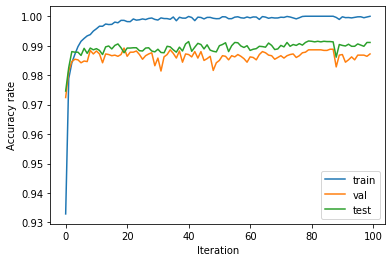

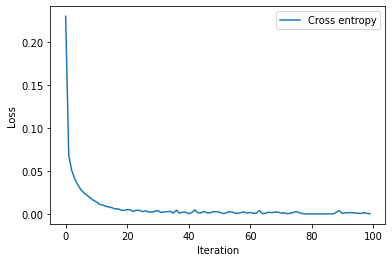

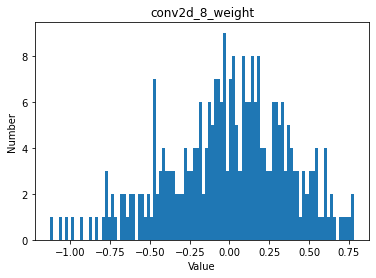

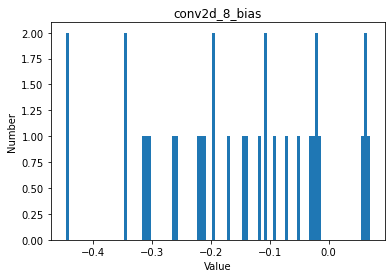

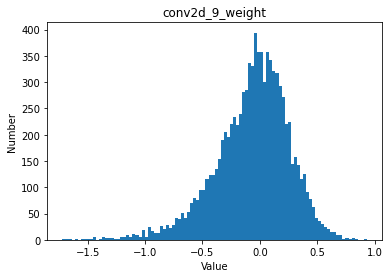

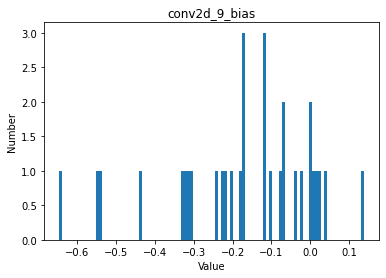

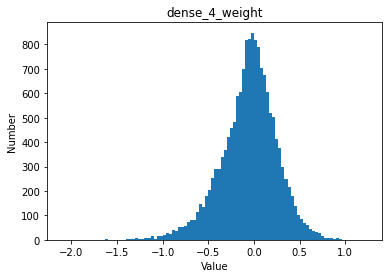

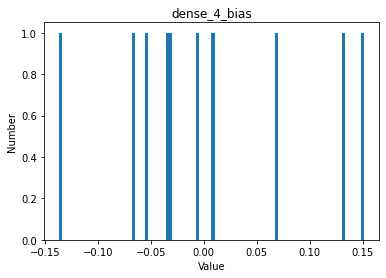

label: 4, pred: 6


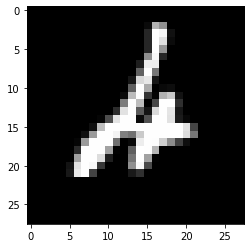

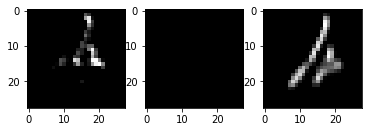

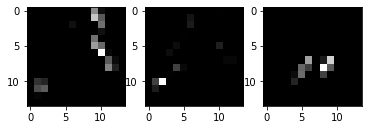

In [65]:
draw_learning_curve(train_acc, val_acc, test_acc)
draw_loss(train_loss)
draw_distributions(model.layers)
img = false_predict(x_test, Y_test, model.predict(x_test))
feature_map(model, img)

In [50]:
input_size = (28,28,1)
kernel_size = (3,3)
stride = (1,1)
model = with_l2(input_size, kernel_size, stride)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                15690     
Total params: 25,258
Trainable params: 25,258
Non-trainable params: 0
__________________________________________________

In [51]:
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = my_train(model, 5)

Epoch 1/5
860/860 [==============================] - 17s 20ms/step - loss: 0.5387 - accuracy: 0.9145 - val_loss: 0.3749 - val_accuracy: 0.9530
Epoch 2/5
860/860 [==============================] - 17s 19ms/step - loss: 0.3566 - accuracy: 0.9562 - val_loss: 0.3428 - val_accuracy: 0.9624
Epoch 3/5
860/860 [==============================] - 16s 19ms/step - loss: 0.3439 - accuracy: 0.9595 - val_loss: 0.3448 - val_accuracy: 0.9612
Epoch 4/5
860/860 [==============================] - 16s 19ms/step - loss: 0.3383 - accuracy: 0.9615 - val_loss: 0.3475 - val_accuracy: 0.9566


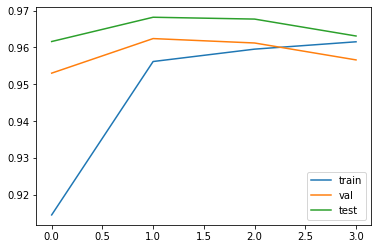

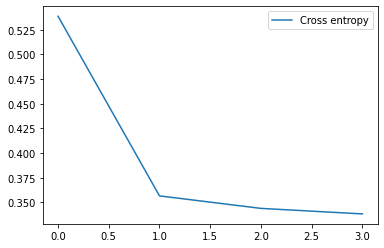

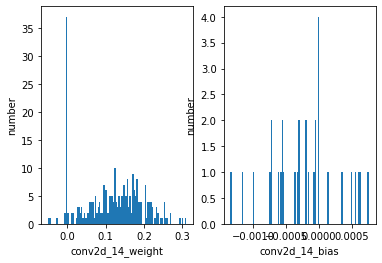

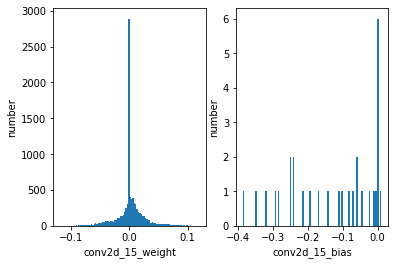

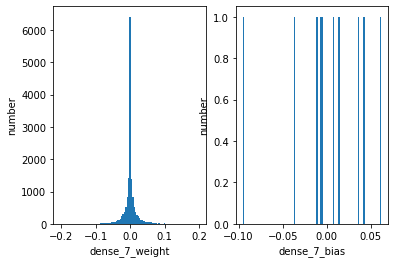

label: 4, pred: 9


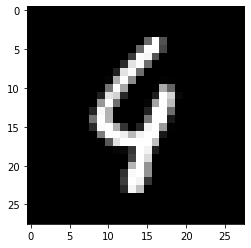

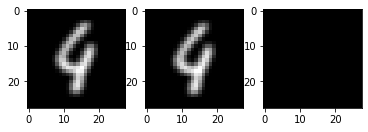

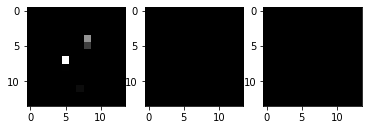

In [52]:
draw_learning_curve(train_acc, val_acc, test_acc)
draw_loss(train_loss)
draw_distributions(model.layers)
img = false_predict(x_test, Y_test, model.predict(x_test))
feature_map(model, img)